Code Runtime is 8 minutes.
A 0.8p.f is applied to the chosen generator size. Recommended minimum size is 250kW to ensure no unmet load.
Please only select in multiples of 10kW.


Input Generator Size (kW):  250


Generator Size: 250.0
Best Configuration for Optimal Cost:
BESS_Power_kW            50
BESS_Energy_kWh          50
Fuel_Cost_£        11527.08
Rent_£               7980.0
Total_Cost_£       19507.08
CO2_kg             23054.16
Unmet_Load_kWh          0.0
Feasible                YES
Name: 0, dtype: object
Best Configuration for Optimal CO2:
BESS_Power_kW           300
BESS_Energy_kWh         300
Fuel_Cost_£        10352.25
Rent_£              32880.0
Total_Cost_£       43232.25
CO2_kg             20704.49
Unmet_Load_kWh          0.0
Feasible                YES
Name: 0, dtype: object


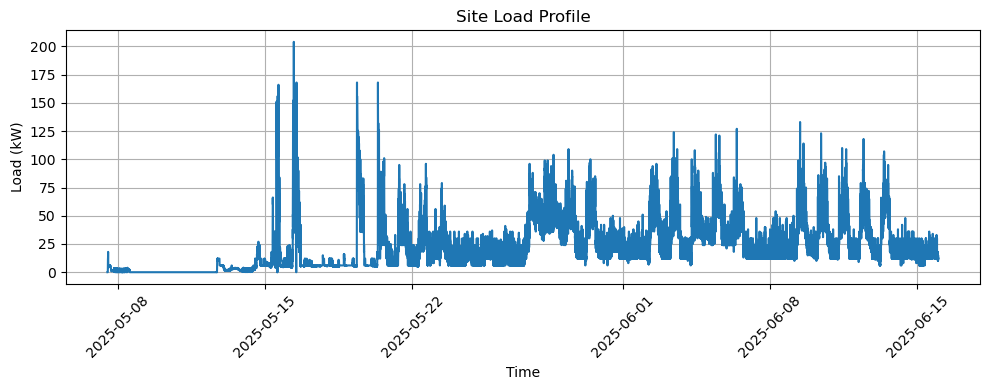

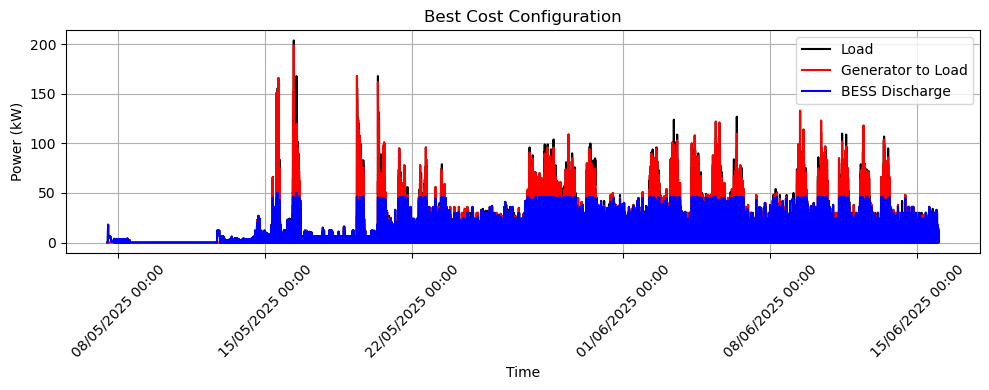

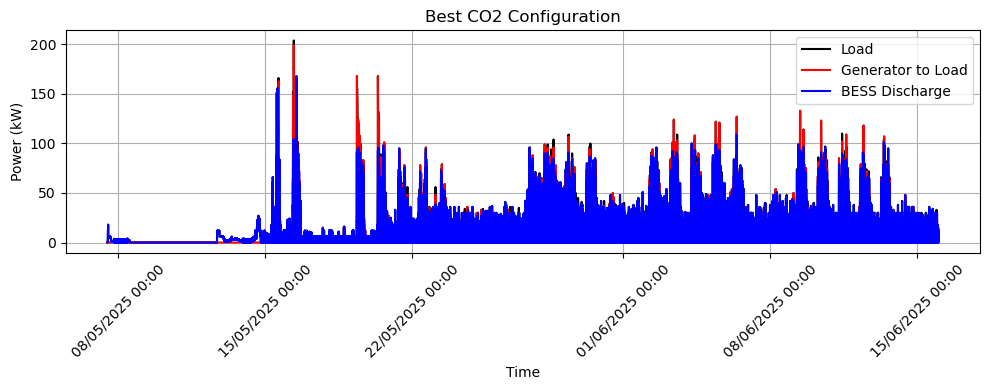

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import re
import itertools
from itertools import product
import time



###################################################################################################################################



# Function to normalize power to kW, converts data to string first
def parse_power_to_kW(x): 
    try:
        s = str(x).strip().lower()
        match = re.match(r'(\d+\.?\d*)\s*(kw|w)', s)
        if not match:
            return None
        value, unit = match.groups()
        value = float(value)
        return value if unit == 'kw' else value / 1000
    except:
        return None



###################################################################################################################################



# Load, clean and format Load Data 
def load_and_prepare(filepath):
    og_load = pd.read_csv(filepath)
    og_load['Load_kW'] = og_load['Power'].apply(parse_power_to_kW)
    og_load['DATETIME'] = pd.to_datetime(og_load['Time'], format='%d/%m/%Y %H:%M').dt.floor('min')
    # Clean NaNs (first pass)
    og_load = og_load.fillna(0)

    # Data Series of Summed load (kW) per minute timestamp
    load = og_load.groupby('DATETIME')['Load_kW'].sum()
    load = load.to_frame(name='Load_kW').reset_index()

    # Filling in data gaps (no data assumed to be 0kW load), after grouping rest of data 
    # Set index to DATETIME for reindexing
    load = load.set_index('DATETIME')

    # Reindex to full range, filling missing minutes with NaN
    expected_index = pd.date_range(start=load.index.min(), end=load.index.max(), freq='1min')
    load = load.reindex(expected_index)
    load = load.rename_axis('DATETIME').reset_index()

    # Clean NaNs (as new NaNs have been created)
    load = load.fillna(0)
    
    return load



###################################################################################################################################



# BESS + Diesel combined model
def hybrid_model(load, gen_size, bess_power, bess_energy, gen_eff, fuel_cost_per_litre, gen_rent_rate_10kW, co2_emm_rate, bess_round_trip_efficiency=0.85):

    # Timestep is 1 minute
    timestep_hours = 1 / 60  

    # Initial SoC is 50%
    soc = 0.5 * bess_energy  
    
    # Initialise Data Columns 
    hybrid_df = load.copy()
    hybrid_df['Gen_Output_kW'] = 0.0
    hybrid_df['BESS_Charge_kW'] = 0.0
    hybrid_df['BESS_Discharge_kW'] = 0.0
    hybrid_df['SOC_kWh'] = 0.0
    hybrid_df['Gen_Fuel_Used_l'] = 0.0

    total_fuel_l = 0.0
    total_unmet_energy_kWh = 0.0

    # Number of Weeks (for rent calculations)
    weeks = 6
    
    # Calculate Rent of Diesel Generator 
    pf = 0.8    
    Pr_gen = (gen_size*pf)
    gen_rent_week = gen_rent_rate_10kW*(gen_size/10)
    gen_rent = gen_rent_week*weeks

    # Calculate Rent of BESS (dictated by power and energy size)
    bess_rent = (weeks)*((100*bess_power/10) + (33*bess_energy/5))


    
    ###############################################
    ###           CALCULATION LOOP              ###
    ###############################################
    
    for i, row in hybrid_df.iterrows():
        load_kw = row['Load_kW']
        
        # BESS SoC limits
        min_soc = 0.1 * bess_energy
        max_soc = 0.9 * bess_energy
        
        # Pre-calculate limits (logic constraints)
        available_discharge_kWh = max(0, soc - min_soc)
        max_bess_discharge_kWh = min(bess_power * timestep_hours, available_discharge_kWh)
        max_bess_discharge_kW = max_bess_discharge_kWh / timestep_hours
        
        max_bess_charge_kWh = max(0, (max_soc - soc))
        max_bess_charge_kW = min(bess_power, max_bess_charge_kWh / timestep_hours)
        
        # Initialise dispatch values
        gen_output = 0
        gen_to_load = 0
        bess_discharge = 0
        bess_charge = 0
        unmet_load = 0

        ###############################################
        ###            DISPATCH LOGIC               ###
        ###############################################

        if soc > min_soc:
            # BESS Discharge 
            bess_discharge = min(load_kw, max_bess_discharge_kW)
            remaining_load = load_kw - bess_discharge
        
            # Generator meets remaining load
            gen_to_load = min(remaining_load, Pr_gen)
            remaining_gen_capacity = Pr_gen - gen_to_load
        
            # If BESS idle, excess Generator capacity charges BESS
            if bess_discharge == 0 and remaining_gen_capacity > 0 and soc < max_soc:
                bess_charge = min(remaining_gen_capacity, max_bess_charge_kW)
            else:
                bess_charge = 0  
        
            # Iteration outputs for this branch
            gen_output = gen_to_load + bess_charge
            unmet_load = max(0, load_kw - bess_discharge - gen_to_load)

        else:
            # SoC too low, no BESS Discharge 
            bess_discharge = 0
            remaining_load = load_kw
        
            # Generator meets full load
            gen_to_load = min(remaining_load, Pr_gen)
            remaining_gen_capacity = Pr_gen - gen_to_load
        
            # Excess Generator capacity charges BESS
            if remaining_gen_capacity > 0 and soc < max_soc:
                bess_charge = min(remaining_gen_capacity, max_bess_charge_kW)
            else:
                bess_charge = 0

            
            gen_output = gen_to_load + bess_charge
            unmet_load = max(0, remaining_load - gen_to_load)

        # Safety (Error) Checks 
        assert not (bess_charge > 0 and bess_discharge > 0), f"Timestep {i}: Charging & discharging simultaneously"
        assert bess_discharge * timestep_hours <= soc + 1e-6, f"Timestep {i}: Over-discharge"
        assert soc <= bess_energy + 1e-6, f"Timestep {i}: SOC exceeded max"

        # Update SoC for i 
        eff = bess_round_trip_efficiency
        eff_charge = eff ** 0.5
        eff_discharge = eff ** 0.5
        
        soc += bess_charge * timestep_hours * eff_charge
        soc -= bess_discharge * timestep_hours / eff_discharge
        
        # Clamp SoC to [0, bess_energy]
        soc = max(0, min(soc, bess_energy))

        # Logging iteration data 
        hybrid_df.at[i, 'Gen_Output_kW'] = gen_output
        hybrid_df.at[i, 'Gen_to_Load_kW'] = gen_to_load
        hybrid_df.at[i, 'BESS_Charge_kW'] = bess_charge
        hybrid_df.at[i, 'BESS_Discharge_kW'] = bess_discharge
        hybrid_df.at[i, 'SOC_kWh'] = soc
        hybrid_df.at[i, 'Unmet_Load_kW'] = unmet_load

        # Fuel calculations
        load_factor = gen_output / Pr_gen if Pr_gen > 0 else 0
        kWh_per_litre = np.interp(load_factor, gen_eff['Pr Percent'], gen_eff['Eff (kWh/Litre)'])
        kWh_per_litre = max(kWh_per_litre, 0.01)
        fuel_l = (gen_output * timestep_hours) / kWh_per_litre
        hybrid_df.at[i, 'Gen_Fuel_L'] = fuel_l
        total_fuel_l += fuel_l
 
    # Calculate total costs and CO2 
    h_total_rent = gen_rent+bess_rent
    h_total_fuel_cost = total_fuel_l * fuel_cost_per_litre
    h_total_cost = h_total_fuel_cost + gen_rent + bess_rent
    h_total_co2_kg = total_fuel_l * co2_emm_rate
        
    return h_total_fuel_cost, h_total_rent, h_total_cost, h_total_co2_kg, hybrid_df 
    pass



###################################################################################################################################



def main():
    
    # Load data (1 minute timestep)
    load = load_and_prepare('Load_data.csv')
    timestep_hours = 1 / 60  

    ###############################################
    ###           ESTABLISH PARAMETERS          ###
    ###############################################
    
    # BESS and Diesel sizing 
    print("Code Runtime is 8 minutes.")
    print("A 0.8p.f is applied to the chosen generator size. Recommended minimum size is 250kW to ensure no unmet load.")
    print("Please only select in multiples of 10kW.")  
    gen_size = float(input("Input Generator Size (kW): "))
    bess_power = [50, 100, 150, 200, 250, 300]  
    bess_energy = [50, 100, 150, 200, 250, 300]  
    
    # Confining BESS configs to standard C-rates
    allowed_c_rates = [0.5, 1, 2] 
    combinations = list(product(bess_power, bess_energy))
    filtered_combinations = [
    (p, e) for p, e in combinations
    if (e == 0 and p == 0) or (e > 0 and any(abs((p / e) - c) < 1e-6 for c in allowed_c_rates))
]
    results = []

    # Diesel generator efficiency curve 
    
    # Generator Efficiency (150kVA) adjusted for selected size 
    gen_eff = pd.read_csv('Gen Eff 150kW.csv')
    fuel_cost_per_litre = 1.43
    # Rent rate = £/week Per 10kW
    gen_rent_rate_10kW = 20    
    co2_emm_rate = 2.86


    
    ###############################################
    ###                RUN MODEL                ###
    ###############################################

    # Run hybrid model
    for bess_power, bess_energy in filtered_combinations:
        h_fuel_cost, h_rent, h_total_cost, h_co2_kg, hybrid_df = hybrid_model(
        load=load,
        gen_size=gen_size,
        bess_power=bess_power,
        bess_energy=bess_energy,
        gen_eff=gen_eff,
        fuel_cost_per_litre=fuel_cost_per_litre,
        gen_rent_rate_10kW=gen_rent_rate_10kW,
        co2_emm_rate=co2_emm_rate,
        bess_round_trip_efficiency=0.85
    )
    
        # Calculate Unmet Load
        if 'Unmet_Load_kW' in hybrid_df.columns:
            total_unmet_energy_kWh = (hybrid_df['Unmet_Load_kW'] * timestep_hours).sum()
        else:
            total_unmet_energy_kWh = 0.0  
    
        results.append({
            "BESS_Power_kW": bess_power,
            "BESS_Energy_kWh": bess_energy,
            "Fuel_Cost_£": round(h_fuel_cost, 2),
            "Rent_£": round(h_rent, 2),
            "Total_Cost_£": round(h_total_cost, 2),
            "CO2_kg": round(h_co2_kg, 2),
            "Unmet_Load_kWh": round(total_unmet_energy_kWh, 3),
            "Feasible": "YES" if total_unmet_energy_kWh < 1e-3 else "NO",
            "df": hybrid_df 
    })
    
        # Table of all BESS power and energy configs with stats 
        results_df = pd.DataFrame(results)
        results_df.to_csv('results_genX.csv', index=False)
        
    # Sort by lowest total cost and CO₂
    sorted_by_cost = results_df.sort_values(by="Total_Cost_£").reset_index(drop=True)
    sorted_by_co2 = results_df.sort_values(by="CO2_kg").reset_index(drop=True)
    print("Generator Size:", gen_size)

    # Identifying best CO2 and Cost configuration
    best_cost_config = sorted_by_cost.iloc[0]
    best_co2_config = sorted_by_co2.iloc[0]

    #Extracting data of best configs
    df_cost_best = best_cost_config['df']
    df_co2_best = best_co2_config['df']
    
    # Printing Results
    # Prints Best Cost BESS Configuration (with stats)
    print("Best Configuration for Optimal Cost:")
    print(best_cost_config.iloc[:8])

    # Prints Best CO2 BESS Configuration (with stats)
    print("Best Configuration for Optimal CO2:")
    print(best_co2_config.iloc[:8]) 



    ###############################################
    ###             VISUALISATIONS              ###
    ###############################################

    # %d/%m/%Y %H:%M
    # Full time data range is 07/05 till 16/06
    ## MODIFY to adjust time period of plots
    #start = "2025-05-16 06:00"
    #end = "2025-05-16 12:00"
    start = "2025-05-07 00:00"
    end = "2025-06-16 00:00"

    # Slicing the data for adjusted time plots 
    df_cost_best["DATETIME"] = pd.to_datetime(df_cost_best["DATETIME"])    # Ensures DATETIME in correct format to be able to slice
    df_cost_sliced = df_cost_best[(df_cost_best["DATETIME"] >= start) & (df_cost_best["DATETIME"] <= end)]
    
    df_co2_best["DATETIME"] = pd.to_datetime(df_co2_best["DATETIME"])    # Ensures DATETIME in correct format to be able to slice
    df_co2_sliced = df_co2_best[(df_co2_best["DATETIME"] >= start) & (df_co2_best["DATETIME"] <= end)]
    
    # Plot Load Profile
    plt.figure(figsize=(10, 4))
    plt.plot(hybrid_df['DATETIME'], hybrid_df['Load_kW'])
    plt.title('Site Load Profile')
    plt.xlabel('Time')
    plt.ylabel('Load (kW)')
    plt.grid(True)
    # Re-format x-axis to reduce number of labels
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.show()

    # Plotting function
    def plot_dispatch(df, title):
        plt.figure(figsize=(10, 4))
        plt.plot(df["DATETIME"], df["Load_kW"], label="Load", color="black")
        #plt.plot(df["DATETIME"], df["Gen_Output_kW"], label="Total Gen Output", color="orange")
        plt.plot(df["DATETIME"], df["Gen_to_Load_kW"], label="Generator to Load", color="red")
        plt.plot(df["DATETIME"], df["BESS_Discharge_kW"], label="BESS Discharge", color="blue")
        #plt.plot(df["DATETIME"], df["BESS_Charge_kW"], label="BESS Charge", color="red")
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Power (kW)')
        plt.legend()
        plt.grid(True)
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
        plt.xticks(rotation=45)  # Rotate labels for readability
        plt.tight_layout()
        plt.show()
        
    ### PLOTTING BEST CONFIGS
    plot_dispatch(df_cost_sliced, 'Best Cost Configuration')
    plot_dispatch(df_co2_sliced, 'Best CO2 Configuration')

# Run Code
main()